# EDA

In [1]:
# import all the necessary libraries/packages
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from geopandas.tools import overlay
import shapely
from shapely.geometry import Point, Polygon,MultiPoint, MultiPolygon
import fiona
import warnings
from pyproj import Proj, transform
import fiona
from fiona.crs import from_epsg
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource
import mplcursors
from sklearn.preprocessing import normalize
from statsmodels.tsa.stattools import adfuller
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar
from bokeh.io import push_notebook, output_notebook
from ipywidgets import interact
import ipywidgets as widgets
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# import csv(restaurants that are currently open in Williamsburg, Bushwick, East Harlem, and Chelsea/Clinton area)
yelp_williamsburg = pd.read_csv('csv/yelp_williamsburg_w_review_date.csv', index_col = 0)
yelp_bushwick = pd.read_csv('csv/yelp_bushwick_w_review_date.csv', index_col = 0)
yelp_east_harlem = pd.read_csv('csv/yelp_east_harlem_w_review_date.csv', index_col = 0)
yelp_chelsea_clinton = pd.read_csv('csv/yelp_chelsea_clinton_w_review_date.csv', index_col = 0)

In [45]:
# yelp_bushwick_categ = pd.read_csv('../yelp_bushwick.csv', index_col = 0)
# yelp_bushwick = yelp_bushwick.drop([266])
# yelp_bushwick = yelp_bushwick.reset_index(drop = True)

In [5]:
williamsburg_id = list(set(yelp_williamsburg.id))

In [46]:
# yelp_bushwick_categ = yelp_bushwick_categ[~yelp_bushwick_categ['id'].isin(williamsburg_id)]
# yelp_bushwick_categ = yelp_bushwick_categ.reset_index(drop = True)
# yelp_bushwick_categ = yelp_bushwick_categ['categories']

In [7]:
length_williamsburg = len(yelp_williamsburg)
length_bushwick = len(yelp_bushwick)
length_east_harlem = len(yelp_east_harlem)

In [8]:
length_chelsea_clinton = len(yelp_chelsea_clinton)

### Data Visualization

- Use shapefile to plot polygons by zipcode, and use restaurant data to plot restaurant locations
- show the change (both in rent and businesses) over time
- understand percent increase in business for each area

In [9]:
# set the dataframe to a different name
yelp_williamsburg_plotly = yelp_williamsburg
yelp_bushwick_plotly = yelp_bushwick
yelp_east_harlem_plotly = yelp_east_harlem 
yelp_chelsea_clinton_plotly = yelp_chelsea_clinton

In [10]:
yelp_chelsea_clinton_plotly = yelp_chelsea_clinton

In [11]:
def df_for_visualization(df):
    df['Coordinates'] = list(zip(df['longitude'], df['latitude'])) # create a new column coordinates (latitude, longitude pair)
    df['Coordinates'] = df['Coordinates'].apply(Point) # change coordinates type to geoppanda's Point
    gdf = gpd.GeoDataFrame(df, geometry='Coordinates') 
    return df, gdf

In [17]:
# # create a new column coordinates (latitude, longitude pair)
# yelp_williamsburg_plotly['Coordinates'] = list(zip(yelp_williamsburg_plotly['longitude'], yelp_williamsburg_plotly['latitude']))

In [13]:
bushwick_plotly_df, gdf_bushwick = df_for_visualization(yelp_bushwick_plotly)
east_harlem_plotly_df, gdf_east_harlem = df_for_visualization(yelp_east_harlem_plotly)

In [14]:
east_chelsea_clinton_df, gdf_chelsea_clinton = df_for_visualization(yelp_chelsea_clinton_plotly)

In [18]:
# # change coordinates type to geoppanda's Point
# yelp_williamsburg_plotly['Coordinates'] = yelp_williamsburg_plotly['Coordinates'].apply(Point)

In [19]:
gdf = gpd.GeoDataFrame(yelp_williamsburg_plotly, geometry='Coordinates')
# gdf = gdf.drop(['Coordinates'], axis = 1)

In [21]:
# shape_file_zip = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp') # geopanda
shape = fiona.open('ZIP_CODE_040114/ZIP_CODE_040114.shp') # open shape file with fiona
shape.crs

{'proj': 'lcc',
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [22]:
# create projection object (use this to transform Polygons from lcc to lat/long)
nc = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs ", preserve_units=True)
# convert Polygon from lcc to lat/long and save the updated version as new.shp
with fiona.open('new.shp', 'w', 'ESRI Shapefile', shape.schema.copy(), crs=from_epsg(4326)) as output:
    for feat in shape: # feat = one polygon of the shapefile
        out_linearRing = [] # empty list for the LinearRing of transformed coordinates
        for point in feat['geometry']['coordinates'][0]: # LinearRing of the Polygon
            long,lat =  point  # one point of the LinearRing
            x,y = nc(long,lat, inverse=True)
            out_linearRing.append((x,y)) # add all the points to the new LinearRing
        # transform the resulting LinearRing to a Polygon and write it
        feat['geometry']['coordinates'] = [out_linearRing]
        output.write(feat)

In [23]:
shape_fiona = gpd.read_file('new.shp') 

In [24]:
# choose polygons to plot area map
ny_bk_qn = shape_fiona[(shape_fiona['COUNTY'] == 'New York') | (shape_fiona['COUNTY'] == 'Kings') | (shape_fiona['COUNTY'] == 'Queens')]
bk = shape_fiona[shape_fiona['COUNTY'] == 'Kings']

In [25]:
# Perform the spatial join - Williamsburg
ny_bk_qn = ny_bk_qn[["ZIPCODE", "geometry"]]
result = gpd.tools.sjoin(gdf, ny_bk_qn, how="left",op="within")

In [26]:
# Perform the spatial join - Williamsburg
result_bushwick = gpd.tools.sjoin(gdf_bushwick, ny_bk_qn, how="left",op="within")
result_east_harlem = gpd.tools.sjoin(gdf_east_harlem, ny_bk_qn, how="left",op="within")

In [27]:
result_chelsea_clinton = gpd.tools.sjoin(gdf_chelsea_clinton, ny_bk_qn, how="left",op="within")

#### Street Score - visualization

In [30]:
# street_score = pd.read_csv('../streetscore_newyorkcity.csv')

In [31]:
# street_score_df, street_score_gdf = df_for_visualization(street_score)

In [32]:
# street_score_gdf.head()

In [ ]:
print(street_score_gdf['q-score'].max())
street_score_gdf['q-score'].min()

In [ ]:
def color_map():
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    jump = 256//5
    cmaplist_ = []
    for item in street_score_gdf['q-score']:
        if -5<=item<5:
            cmaplist_.append(cmaplist[jump*0])
        if 5<= item <15:
            cmaplist_.append(cmaplist[jump*1])
        if 15<= item < 25:
            cmaplist_.append(cmaplist[jump*2])
        if 25<= item < 35:
            cmaplist_.append(cmaplist[jump*3])
        if 35<= item < 45:
            cmaplist_.append(cmaplist[jump*4])
    return cmaplist_

In [ ]:
colors = color_map()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ny_bk_qn.plot(ax=ax, color="blue")
street_score_gdf.plot(ax=ax,markersize=1, color = colors)
plt.show()

In [ ]:
result_chelsea_clinton = result_chelsea_clinton[result_chelsea_clinton['latitude']<=41]
result_chelsea_clinton = result_chelsea_clinton[(result_chelsea_clinton['longitude']>=-74.1)&(result_chelsea_clinton['longitude']<=-73.8)]

### Visualization - Williamsburg, Bushwick and East Harlem

In [33]:
custom_colors = ['#f2f2f2', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']

In [34]:
result_bushwick = result_bushwick[result_bushwick['longitude']>90]

In [ ]:
# fig, ax = plt.subplots(1, figsize=(20, 10))
# ny_bk_qn.plot(ax=ax, color= custom_colors[0])
# result_bushwick.plot(ax=ax, markersize=2, color="black")
# result_east_harlem.plot(ax=ax, markersize=2, color="green")
# result_chelsea_clinton.plot(ax=ax, markersize=2, color="blue")
# result.plot(ax=ax, markersize=2, color="red")
# plt.show()

In [35]:
williamsburg_geo = ny_bk_qn[(ny_bk_qn['ZIPCODE'] == '11211')|(ny_bk_qn['ZIPCODE'] =='11206')|(ny_bk_qn['ZIPCODE'] =='11237')]
bushwick_geo = ny_bk_qn[(ny_bk_qn['ZIPCODE'] == '11221')]
chelsea_clinton_geo = ny_bk_qn[(ny_bk_qn['ZIPCODE'] == '10001')|(ny_bk_qn['ZIPCODE'] == '10011')|(ny_bk_qn['ZIPCODE'] == '10018')|(ny_bk_qn['ZIPCODE'] == '10019')|(ny_bk_qn['ZIPCODE'] == '10020')|(ny_bk_qn['ZIPCODE'] == '10036')]
east_harlem_geo = ny_bk_qn[(ny_bk_qn['ZIPCODE'] =='10029')|(ny_bk_qn['ZIPCODE'] =='10035')]
bk_wo_williamsburg_bushwick = ny_bk_qn[(ny_bk_qn['ZIPCODE'] != '11211')&(ny_bk_qn['ZIPCODE'] !='11206')&(ny_bk_qn['ZIPCODE'] !='11237')&(ny_bk_qn['ZIPCODE'] != '11221')&(ny_bk_qn['ZIPCODE'] !='10029')&(ny_bk_qn['ZIPCODE'] !='10035')&(ny_bk_qn['ZIPCODE'] != '10001')&(ny_bk_qn['ZIPCODE'] != '10011')&(ny_bk_qn['ZIPCODE'] != '10018')&(ny_bk_qn['ZIPCODE'] != '10019')&(ny_bk_qn['ZIPCODE'] != '10020')&(ny_bk_qn['ZIPCODE'] != '10036')]

In [ ]:
# fig, ax = plt.subplots(1, figsize=(25, 15))
# williamsburg_geo.plot(ax=ax, color = custom_colors[3])
# bushwick_geo.plot(ax=ax, color = custom_colors[1])
# east_harlem_geo.plot(ax=ax, color = custom_colors[2])
# chelsea_clinton_geo.plot(ax=ax, color = custom_colors[4])
# bk_wo_williamsburg_bushwick.plot(ax=ax, color=custom_colors[0])
# result.plot(ax=ax, markersize=1, color="red")
# result_bushwick.plot(ax=ax, markersize=1, color="black")
# result_east_harlem.plot(ax=ax, markersize=1, color="green")
# result_chelsea_clinton.plot(ax=ax, markersize=2, color="blue")
# plt.show()

In [ ]:
# from bokeh.layouts import column, row, widgetbox
# from bokeh.models import CustomJS, Slider, Toggle

# output_file("rent_dynamic_interactive_test.html")

# # add slider with callback to update data source
# slider = Slider(start=, end=23, value=0, step=1, title="Hour of day")

# def update(source=source, slider=slider, window=None):
#     """ Update the map: change the bike density measure according to slider
#         will be translated to JavaScript and Called in Browser """
#     data = source.data
#     v = cb_obj.get('value')
#     data['rate'] = [x for x in data[v]]
#     source.trigger('change')

# slider.js_on_change('value', CustomJS.from_py_func(update))
# show(column(p,widgetbox(slider),))

### Data Manipulation and EDA

In [48]:
def data_manipulation(df, length):
    #change price to int. (count of dollar signs) from $$ 
    df['price'] = [len(df['price'][i]) if ~df['price'].isnull()[i] else np.nan for i in range(0, length)]
    #remove empty list and change the data type to datetime
    df['oldest_review'] = df['oldest_review'].apply(lambda y: np.nan if len(y)==2 else y)
    df['oldest_review'] = pd.to_datetime(df['oldest_review'])
    # get count of reviews per month
    group_by = df.groupby(df['oldest_review'].dt.to_period("M")).agg('count')
    return df, group_by

In [49]:
yelp_bushwick_cleaned, group_by_bushwick = data_manipulation(yelp_bushwick, length_bushwick)
yelp_east_harlem_cleaned, group_by_east_harlem = data_manipulation(yelp_east_harlem, length_east_harlem)

In [50]:
yelp_williamsburg_cleaned, group_by_williamsburg = data_manipulation(yelp_williamsburg, length_williamsburg)

In [51]:
yelp_chelsea_clinton_cleaned, group_by_chelsea_clinton = data_manipulation(yelp_chelsea_clinton, length_chelsea_clinton)

In [ ]:
# # THIS IS PUT TOGETHER IN THE FUNCTION ABOVE
# # change price to int. (count of dollar signs) from $$ 
# # yelp_williamsburg['price'] = [len(yelp_williamsburg['price'][i]) if ~yelp_williamsburg['price'].isnull()[i] else np.nan for i in range(0, length_williamsburg)]
# # remove empty list and change the data type to datetime
# yelp_williamsburg['oldest_review'] = yelp_williamsburg['oldest_review'].apply(lambda y: np.nan if len(y)==2 else y)
# yelp_williamsburg['oldest_review'] = pd.to_datetime(yelp_williamsburg['oldest_review'])
# # get count of reviews per month
# group_by = yelp_williamsburg.groupby(yelp_williamsburg['oldest_review'].dt.to_period("M")).agg('count')

In [65]:
# williamsburg_category_count = yelp_williamsburg.groupby('category').count()
# williamsburg_category_count = williamsburg_category_count.sort_values(by = ['alias'], ascending = False)
# williamsburg_category_count = williamsburg_category_count['alias']
# # williamsburg_category_count

In [74]:
# yelp_bushwick_cleaned = yelp_bushwick_cleaned.drop(['categories'], axis = 1)

In [76]:
# yelp_bushwick = yelp_bushwick.drop(['avg_rating', "avg_price"], axis = 1)
yelp_bushwick_cleaned = pd.concat([yelp_bushwick_cleaned,yelp_bushwick_categ[:405]], axis = 1)
# yelp_bushwick_cleaned = yelp_bushwick_cleaned[:405]
# yelp_bushwick_cleaned['categories'] = yelp_bushwick_cleaned['categories'].apply(lambda x: ast.literal_eval(x)) 
cat = [yelp_bushwick_cleaned['categories'][i][0]['alias'] if yelp_bushwick_cleaned['categories'][i] != [] else None for i in range(0, length_bushwick-1)]
yelp_bushwick_cleaned['category'] = pd.Series(cat)

In [77]:
# count of restaurants Top 10
top_10_cat_williamsburg = williamsburg_category_count[:11]
100*top_10_cat_williamsburg/length_williamsburg

category
bars            8.847737
coffee          6.652949
mexican         6.447188
pizza           5.075446
delis           4.183813
chinese         4.046639
bakeries        3.635117
newamerican     3.360768
cocktailbars    2.812071
italian         2.263374
latin           2.263374
Name: alias, dtype: float64

In [78]:
bushwick_category_count = yelp_bushwick_cleaned.groupby('category').count()
bushwick_category_count = bushwick_category_count.sort_values(by = ['alias'], ascending = False)
bushwick_category_count = bushwick_category_count['alias']
100*bushwick_category_count[:11]/length_bushwick

category
coffee          9.852217
pizza           6.650246
chinese         5.911330
caribbean       4.926108
bakeries        4.679803
bars            3.448276
mexican         2.955665
indpak          2.955665
cocktailbars    2.709360
delis           2.709360
cafes           2.463054
Name: alias, dtype: float64

TypeError: 'numpy.ndarray' object is not callable

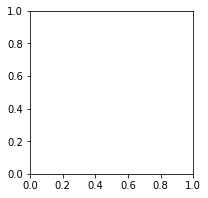

In [264]:
data = 100*bushwick_category_count[:11]/length_bushwick
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
label = bushwick_category_count.keys()[:11]

def func(pct):
    return "{:.1f}%".format(pct)

wedges, texts, autotexts = ax.pie(data, autopct=list(data.values()), textprops=dict(color="w"))

ax.pie(data, labels = label)
ax.legend(wedges, label,
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Top 10 business category - Bushwick")
plt.show

In [79]:
east_harlem_category_count = yelp_east_harlem_cleaned.groupby('category').count()
east_harlem_category_count = east_harlem_category_count.sort_values(by = ['alias'], ascending = False)
east_harlem_category_count = east_harlem_category_count['alias']
100*east_harlem_category_count[:11]/length_east_harlem

category
mexican     7.819905
chinese     7.819905
pizza       6.398104
bakeries    5.687204
delis       5.450237
coffee      3.791469
latin       3.080569
hotdogs     2.843602
cafes       2.369668
desserts    2.369668
burgers     2.369668
Name: alias, dtype: float64

In [80]:
chelsea_clinton_category_count = yelp_chelsea_clinton.groupby('category').count()
chelsea_clinton_category_count = chelsea_clinton_category_count.sort_values(by = ['alias'], ascending = False)
chelsea_clinton_category_count = chelsea_clinton_category_count['alias']
100*(chelsea_clinton_category_count[:11]/length_chelsea_clinton)

category
italian         7.085714
newamerican     6.438095
coffee          5.980952
pizza           3.733333
japanese        3.276190
bakeries        2.819048
mexican         2.742857
bars            2.590476
tradamerican    2.590476
french          2.247619
sushi           2.209524
Name: alias, dtype: float64

In [84]:
# list of category to focus on for this project (top 10 categories from williamsburg data)
list_of_restaurant_cat = list(top_10_cat_williamsburg.keys())
# list_of_restaurant_cat

In [82]:
# count number of new restaurants in the top 10 category list, per month
def df_with_list_of_restaurant_cat(category_list, df):
    for cat in category_list:
        df[cat] = (df['category'] == cat).astype('int')
    return df

In [85]:
yelp_williamsburg = df_with_list_of_restaurant_cat(list_of_restaurant_cat, yelp_williamsburg)
# aggregate
group_by_cat_count = yelp_williamsburg.groupby(yelp_williamsburg['oldest_review'].dt.to_period("M")).agg('sum')

In [87]:
# yelp_williamsburg_count_cat = group_by_cat_count.loc[:, list_of_restaurant_cat[0]:]
# yelp_williamsburg_count_cat['total_count'] = group_by['alias']

In [88]:
# group by month and take means for prices/rating
yelp_williamsburg_avg_by_month = yelp_williamsburg.groupby(yelp_williamsburg['oldest_review'].dt.to_period("M")).agg('mean')
yelp_williamsburg_price_avg = yelp_williamsburg_avg_by_month['price']
yelp_williamsburg_rating_avg = yelp_williamsburg_avg_by_month['rating']

In [89]:
# create new columns for avg rating and price
yelp_williamsburg_count_cat['avg_rating'] = yelp_williamsburg_rating_avg
yelp_williamsburg_count_cat['avg_price'] = yelp_williamsburg_price_avg

In [204]:
# cut off the time
yelp_williamsburg_count_cat = yelp_williamsburg_count_cat.loc[(yelp_williamsburg_count_cat.index >= '2011-11') & (yelp_williamsburg_count_cat.index < '2018-09')]
yelp_williamsburg_count_cat.index = rent_studio_williamsburg.index

In [205]:
yelp_williamsburg_one_hot_cumsum.index = rent_studio_williamsburg.index

In [206]:
williamsburg_cumsum_avg_rent = pd.concat([yelp_williamsburg_one_hot_cumsum, yelp_williamsburg_count_cat.loc[:,'avg_rating':'avg_price'],rent_studio_williamsburg], axis = 1)

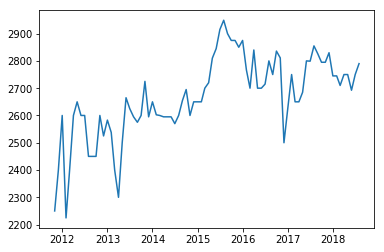

In [207]:
plt.plot(williamsburg_cumsum_avg_rent['rent'])

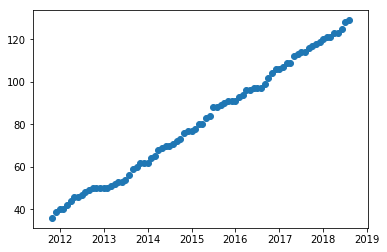

In [208]:
plt.scatter(williamsburg_cumsum_avg_rent.index, williamsburg_cumsum_avg_rent['category_bars'])

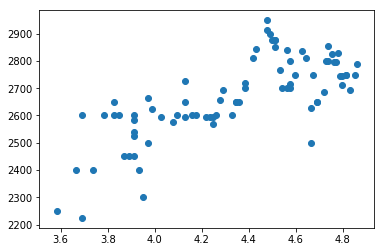

In [209]:
plt.scatter(np.log(williamsburg_cumsum_avg_rent['category_bars']), williamsburg_cumsum_avg_rent['rent'])

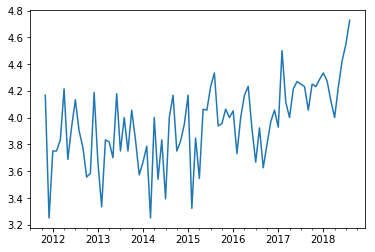

In [210]:
yelp_williamsburg_count_cat['avg_rating'].plot()

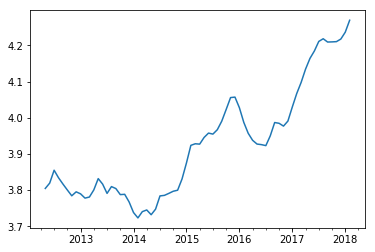

In [214]:
# yelp_williamsburg_count_cat['avg_rating'].plot()
avg_rating_decomp = seasonal_decompose(yelp_williamsburg_count_cat['avg_rating'])
avg_rating_decomp.trend.plot()
# trend_williamsburg.plot()

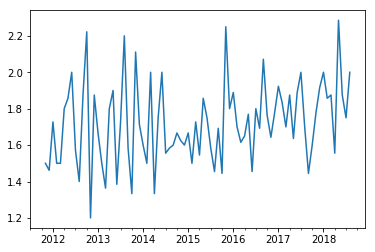

In [215]:
yelp_williamsburg_count_cat['avg_price'].plot()

In [216]:
yelp_williamsburg_count_cat.index = rent_studio_williamsburg.index

In [217]:
yelp_williamsburg_count_cat.head()

,bars,coffee,mexican,pizza,delis,chinese,bakeries,newamerican,cocktailbars,italian,latin,avg_rating,avg_price
2011-11-01,0,1,0,0,0,0,0,1,0,0,2,4.166667,1.500000
2011-12-01,3,0,0,1,1,2,0,0,0,0,1,3.250000,1.461538
2012-01-01,1,1,1,0,1,1,0,0,0,0,0,3.750000,1.727273
2012-02-01,0,1,0,0,0,0,0,0,0,0,0,3.750000,1.500000
2012-03-01,2,0,0,0,0,0,0,0,0,0,0,3.833333,1.500000


In [218]:
# def percentage_each_cat(df, category_list):
#     for item in category_list:
#         column = item + '_%'
#         df[column] = 100*(df[item]/df['total_count'])
#     return df

In [219]:
# yelp_williamsburg_count_cat = percentage_each_cat(yelp_williamsburg_count_cat,list_of_restaurant_cat )

In [220]:
def one_hot_encoding_w_category(df):
    df_one_hot = df[['alias', 'category', 'oldest_review']]
    df_one_hot = pd.get_dummies(df_one_hot, columns = ['category'])
    df_one_hot = df_one_hot.groupby(df_one_hot['oldest_review'].dt.to_period("M")).agg('sum')
    one_hot_cumsum = df_one_hot.cumsum()
    one_hot_cumsum = one_hot_cumsum[(one_hot_cumsum.index >= "2011-11")&(one_hot_cumsum.index < "2018-09")]
    return df_one_hot, one_hot_cumsum

In [221]:
## PUT THESE TOGETHER IN THE FUNCTION ABOVE
yelp_williamsburg_one_hot_category = yelp_williamsburg[['alias', 'category', 'oldest_review']]
yelp_williamsburg_one_hot_category = pd.get_dummies(yelp_williamsburg_one_hot_category, columns = ['category'])
yelp_williamsburg_one_hot = yelp_williamsburg_one_hot_category.groupby(yelp_williamsburg_one_hot_category['oldest_review'].dt.to_period("M")).agg('sum')
yelp_williamsburg_one_hot_cumsum = yelp_williamsburg_one_hot.cumsum()
yelp_williamsburg_one_hot_cumsum = yelp_williamsburg_one_hot_cumsum[(yelp_williamsburg_one_hot_cumsum.index >= "2011-11")&(yelp_williamsburg_one_hot_cumsum.index < "2018-09")]

In [222]:
yelp_williamsburg_one_hot_category, yelp_williamsburg_one_hot_cumsum = one_hot_encoding_w_category(yelp_williamsburg_cleaned)

In [223]:
yelp_williamsburg_one_hot_category = yelp_williamsburg_one_hot_category[yelp_williamsburg_one_hot_category.index >= '2011-11']

In [224]:
yelp_bushwick_one_hot_category, yelp_bushwick_one_hot_cumsum = one_hot_encoding_w_category(yelp_bushwick_cleaned)
yelp_east_harlem_one_hot_category, yelp_east_harlem_one_hot_cumsum = one_hot_encoding_w_category(yelp_east_harlem_cleaned)

In [225]:
yelp_bushwick_one_hot_category.to_csv('bushwick_one_hot_cat.csv')
yelp_williamsburg_one_hot_category.to_csv('williamsburg_one_hot_category.csv')
yelp_chelsea_clinton_one_hot_category.to_csv('chelsea_clinton_one_hot_category.csv')
yelp_east_harlem_one_hot_category.to_csv('east_harlem_one_hot_category.csv')

In [226]:
yelp_chelsea_clinton_one_hot_category, yelp_chelsea_clinton_one_hot_cumsum = one_hot_encoding_w_category(yelp_chelsea_clinton_cleaned)

In [227]:
def normalize(df):
    max_ = df.max()
    min_ = df.min()
    norm = (df - bmin_)/(max_-min_)
    return norm

In [241]:
yelp_williamsburg_one_hot_cumsum.to_csv('yelp_williamsburg_one_hot_cumsum.csv')
yelp_bushwick_one_hot_cumsum.to_csv('yelp_bushwick_one_hot_cumsum.csv')
yelp_east_harlem_one_hot_cumsum.to_csv('yelp_east_harlem_one_hot_cumsum.csv')
yelp_chelsea_clinton_one_hot_cumsum.to_csv('yelp_chelsea_clinton_one_hot_cumsum.csv')

In [228]:
# cafe
# williamsburg
cafe_williamsburg = yelp_williamsburg_one_hot_cumsum['category_coffee']
# bushwick
cafe_bushwick = yelp_bushwick_one_hot_cumsum['category_coffee']
#east harlem 
cafe_east_harlem = yelp_east_harlem_one_hot_cumsum['category_coffee']

#chelsea clinton 
cafe_chelsea_clinton = yelp_chelsea_clinton_one_hot_cumsum['category_coffee']

In [229]:
yelp_williamsburg_cafe_perc_change = cafe_williamsburg.apply(lambda x: 100*(x - cafe_williamsburg.iloc[0])/cafe_williamsburg.iloc[0])
yelp_bushwick_cafe_perc_change = cafe_bushwick.apply(lambda x: 100*(x - cafe_bushwick.iloc[0])/cafe_bushwick.iloc[0])
yelp_east_harlem_cafe_perc_change = cafe_east_harlem.apply(lambda x: 100*(x - cafe_east_harlem.iloc[0])/cafe_east_harlem.iloc[0])
yelp_chelsea_clinton_cafe_perc_change = cafe_chelsea_clinton.apply(lambda x: 100*(x - cafe_chelsea_clinton.iloc[0])/cafe_chelsea_clinton.iloc[0])

Text(0.5,1,'cumulative growth in cafes')

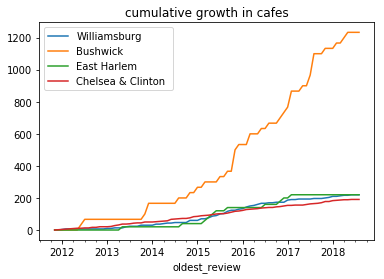

In [231]:
yelp_williamsburg_cafe_perc_change.plot()
yelp_bushwick_cafe_perc_change.plot()
yelp_east_harlem_cafe_perc_change.plot()
yelp_chelsea_clinton_cafe_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea & Clinton "])
plt.title('cumulative growth in cafes')

In [232]:
# bars
# williamsburg
bars_williamsburg = yelp_williamsburg_one_hot_cumsum['category_bars']
# bushwick
bars_bushwick = yelp_bushwick_one_hot_cumsum['category_bars']
bars_bushwick = bars_bushwick[bars_bushwick.index >= '2012-05-01']
#east harlem 
bars_east_harlem = yelp_east_harlem_one_hot_cumsum['category_bars']
#chelsea clinton
bars_chelsea_clinton = yelp_chelsea_clinton_one_hot_cumsum['category_bars']

In [233]:
yelp_williamsburg_bars_perc_change = bars_williamsburg.apply(lambda x: 100*(x - bars_williamsburg.iloc[0])/bars_williamsburg.iloc[0])
yelp_bushwick_bars_perc_change = bars_bushwick.apply(lambda x: 100*(x - bars_bushwick.iloc[0])/bars_bushwick.iloc[0])
yelp_east_harlem_bars_perc_change = bars_east_harlem.apply(lambda x: 100*(x - bars_east_harlem.iloc[0])/bars_east_harlem.iloc[0])
yelp_chelsea_clinton_bars_perc_change = bars_chelsea_clinton.apply(lambda x: 100*(x - bars_chelsea_clinton.iloc[0])/bars_chelsea_clinton.iloc[0])

Text(0.5,1,'cumulative growth in bars')

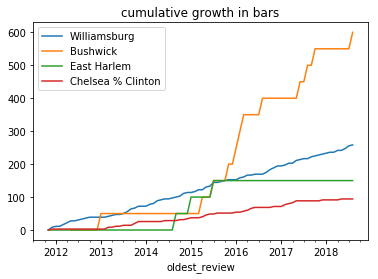

In [234]:
yelp_williamsburg_bars_perc_change.plot()
yelp_bushwick_bars_perc_change.plot()
yelp_east_harlem_bars_perc_change.plot()
yelp_chelsea_clinton_bars_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea % Clinton"])
plt.title('cumulative growth in bars')

In [235]:
# yelp_williamsburg_one_hot_cumsum.sum(axis = 1).pct_change().cumsum().plot()
# yelp_bushwick_one_hot_cumsum.sum(axis = 1).pct_change().cumsum().plot()
# plt.legend(['Williamsburg', 'Bushwick'])

In [236]:
yelp_williamsburg_one_hot_cumsum_all_buss = yelp_williamsburg_one_hot_cumsum.sum(axis = 1)
yelp_bushwick_one_hot_cumsum_all_buss = yelp_bushwick_one_hot_cumsum.sum(axis = 1)
yelp_east_harlem_one_hot_cumsum_all_buss = yelp_east_harlem_one_hot_cumsum.sum(axis = 1)
yelp_chelsea_clinton_one_hot_cumsum_all_buss = yelp_chelsea_clinton_one_hot_cumsum.sum(axis = 1)
yelp_williamsburg_all_buss_perc_change = yelp_williamsburg_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])/yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])
yelp_bushwick_all_buss_perc_change = yelp_bushwick_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])/yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])
yelp_east_harlem_all_buss_perc_change = yelp_east_harlem_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])/yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])

In [237]:
yelp_williamsburg_all_buss_perc_change = yelp_williamsburg_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])/yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])
yelp_bushwick_all_buss_perc_change = yelp_bushwick_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])/yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])
yelp_east_harlem_all_buss_perc_change = yelp_east_harlem_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])/yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])

In [238]:
yelp_chelsea_clinton_all_buss_perc_change = yelp_chelsea_clinton_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_chelsea_clinton_one_hot_cumsum_all_buss.iloc[0])/yelp_chelsea_clinton_one_hot_cumsum_all_buss.iloc[0])

In [239]:
# yelp_williamsburg_normalized.plot()
# yelp_bushwick_normalized.plot()

Text(0.5,1,'cumulative growth in businesses')

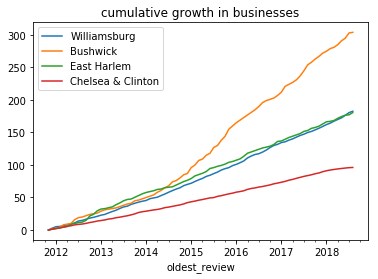

In [240]:
yelp_williamsburg_all_buss_perc_change.plot()
yelp_bushwick_all_buss_perc_change.plot()
yelp_east_harlem_all_buss_perc_change.plot()
yelp_chelsea_clinton_all_buss_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea & Clinton"])
plt.title('cumulative growth in businesses')

#### Rent - Studio

In [94]:
rent_studio = pd.read_csv('csv/Zip_MedianRentalPrice_Studio.csv')
zip_code_list = pd.read_csv('csv/zipcode_by_neighborhood.csv', index_col = 0)

In [95]:
ny_rent_studio = rent_studio[(rent_studio.CountyName == 'Kings')|(rent_studio.CountyName == 'New York')|(rent_studio.CountyName == 'Queens')]

In [96]:
# ny_rent_studio = ny_rent_studio.reset_index()
# ny_rent_studio = ny_rent_studio.drop(['index'], axis = 1)
region = ny_rent_studio.loc[: ,'RegionName':'SizeRank'] 
rent_ = ny_rent_studio.loc[: , '2011-11':] 
ny_rent_studio = pd.concat([region, rent_], axis = 1)

In [97]:
# ny_rent_studio = ny_rent_studio.dropna()
ny_rent_studio = ny_rent_studio.reset_index()

In [98]:
ny_rent_studio = ny_rent_studio.drop(['index'], axis =1)

In [99]:
ny_rent_studio['%_increase'] = 100*(ny_rent_studio['2018-08'] - ny_rent_studio['2011-11'])/ny_rent_studio['2011-11']

In [100]:
ny_rent_studio.to_csv('ny_rent_studio.csv')

In [101]:
ny_rent_studio['%_increase'].mean()

21.043191895218484

In [102]:
# Perform the spatial join
ny_bk_qn = ny_bk_qn[["ZIPCODE", "geometry"]]

In [103]:
ny_bk_qn.columns = ['RegionName', "geometry"]

In [104]:
zip_over_23_increase = ny_rent_studio[ny_rent_studio['%_increase'] > 23]
zip_over_23_increase = list(zip_over_23_increase['RegionName'].values)
zip_over_23_increase = [str(zip_) for zip_ in zip_over_23_increase]

In [107]:
# over_23_increase = ny_bk_qn[ny_bk_qn['ZIPCODE'].isin(zip_over_23_increase)]

In [108]:
# zip_18_23_increase = ny_rent_studio[(ny_rent_studio['%_increase'] <= 23)&(ny_rent_studio['%_increase'] > 18)]
# zip_18_23_increase = list(zip_18_23_increase['RegionName'].values)
# zip_18_23_increase = [str(zip_) for zip_ in zip_18_23_increase]

In [109]:
# _18_23_increase = ny_bk_qn[ny_bk_qn['ZIPCODE'].isin(zip_18_23_increase)]

In [110]:
# zip_below_18_increase = ny_rent_studio[(ny_rent_studio['%_increase'] <= 18)]
# zip_below_18_increase = list(zip_below_18_increase['RegionName'].values)
# zip_below_18_increase = [str(zip_) for zip_ in zip_below_18_increase]

In [112]:
# below_18_increase = ny_bk_qn[ny_bk_qn['ZIPCODE'].isin(zip_below_18_increase)]

In [113]:
# other = ny_bk_qn[(~ny_bk_qn['ZIPCODE'].isin(list(below_18_increase['ZIPCODE'].values)))&(~ny_bk_qn['ZIPCODE'].isin(list(_18_23_increase['ZIPCODE'].values)))&(~ny_bk_qn['ZIPCODE'].isin(list(over_23_increase['ZIPCODE'].values)))]

In [114]:
ny_bk_qn.RegionName = ny_bk_qn.RegionName.astype('int')

In [117]:
shape_fiona_for_plot = shape_fiona[['ZIPCODE', 'geometry']]
shape_fiona_for_plot.columns =  ['RegionName', 'geometry']
shape_fiona_for_plot.RegionName = shape_fiona_for_plot.RegionName.astype('int')

In [118]:
ny_qn_bk_studio_df = shape_fiona_for_plot.merge(ny_rent_studio, how = 'left', on = ['RegionName'])

In [120]:
district_zipcode = shape_fiona_for_plot.RegionName
district_x = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][0]
              for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]
district_y = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][1]
                for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]
# district_xy = [ [ xy for xy in feat["geometry"]["coordinates"][0]] for feat in shape] 
# district_poly = [Polygon(xy) for xy in district_xy]

# rent_price = ny_qn_bk_studio_df['2011-11']

In [ ]:
# district_zipcode = [feat['properties']['ZIPCODE'] for feat in shape]
# district_x = [ [x[0] for x in feat["geometry"]["coordinates"][0]] for feat in shape]
# district_y = [ [y[1] for y in feat["geometry"]["coordinates"][0]] for feat in shape]
# district_xy = [ [ xy for xy in feat["geometry"]["coordinates"][0]] for feat in shape] 
# district_poly = [Polygon(xy) for xy in district_xy]

# rent_price = ny_qn_bk_studio_df['2011-11']

In [184]:
year = ny_qn_bk_studio_df.columns[7:89]

In [171]:
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar
from bokeh.io import push_notebook, output_notebook
from ipywidgets import interact
import ipywidgets as widgets

In [166]:
rent_list = [ny_qn_bk_studio_df[year_] for year_ in year]
rent_dict = dict(zip(year,rent_list))
data = dict(x=district_x, y=district_y, name=district_zipcode,
            rate=rent_list[0], **rent_dict)
source = ColumnDataSource(data)

In [181]:
# ny_qn_bk_studio_df.to_csv('ny_qn_bk_studio_df_bokeh.csv')
# shape_fiona_for_plot.to_csv('shape_fiona_for_plot.csv')

In [174]:
output_notebook()

custom_colors = ['#f2f2f2', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
color_mapper = LogColorMapper(palette=custom_colors)  

TOOLS = "pan,wheel_zoom,reset,hover,save"
p = figure(
    title="Rental Prices", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None
p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.3)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("zipcode", "@name"),("rent ($)", "@rate"),("(Long, Lat)", "($x, $y)")]
# show(p, notebook_handle = True)

w = widgets.SelectionSlider(options=year,value=year[0],disabled=False,continuous_update=False,
                                               orientation='horizontal',readout=True)
def update(w):
    source.data['rate'] = source.data[w]
    show(p, notebook_handle=True)
    push_notebook()
    
interact(update, w = w)

Loading BokehJS ...

interactive(children=(SelectionSlider(continuous_update=False, description='w', options=('2011-11', '2011-12',…

<function __main__.update(w)>

In [177]:
sorted_rent_increase = ny_rent_studio.sort_values(['%_increase'], ascending = False)

In [178]:
# sorted_rent_increase = sorted_rent_increase.reset_index()
# sorted_rent_increase = sorted_rent_increase.drop(['level_0', 'index'], axis = 1)
sorted_rent_increase_top_10 = sorted_rent_increase.loc[:10]

In [179]:
sorted_rent_increase_top_10 = sorted_rent_increase.loc[:10]
region_name_top_10 = sorted_rent_increase_top_10.loc[:,'RegionName':'CountyName']
increase_top_10 = sorted_rent_increase_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_top_10 = pd.concat([region_name_top_10, increase_top_10], axis = 1)
sorted_rent_top_10 = sorted_rent_top_10.reset_index(drop = True)
sorted_rent_top_10 = sorted_rent_top_10.loc[:10]
sorted_rent_top_10['neighborhood'] = ['Flushing', 'Forest Hills', 'Bushwick', 'Rego Park', 'Elmhurst','Midtown East', 'Upper West Side', 'Meatpacking', 'Battery Park', 'City Hall', 'Williamsburg']
sorted_rent_top_10

,RegionName,City,State,Metro,CountyName,2018-08,%_increase,neighborhood
0,11355,New York,NY,"New York, NY",Queens,1900.0,51.636073,Flushing
1,11375,New York,NY,"New York, NY",Queens,1925.0,45.283019,Forest Hills
2,11221,New York,NY,"New York, NY",Kings,2000.0,39.372822,Bushwick
3,11374,New York,NY,"New York, NY",Queens,1750.0,37.254902,Rego Park
4,11373,New York,NY,"New York, NY",Queens,1600.0,33.891213,Elmhurst
5,10022,New York,NY,"New York, NY",New York,2750.0,30.952381,Midtown East
6,10025,New York,NY,"New York, NY",New York,2450.0,28.947368,Upper West Side
7,10014,New York,NY,"New York, NY",New York,3210.0,28.400000,Meatpacking
8,10280,New York,NY,"New York, NY",New York,3500.0,27.272727,Battery Park
9,10038,New York,NY,"New York, NY",New York,3125.0,24.180409,City Hall


In [185]:
sorted_rent_increase_asc = ny_rent_studio.sort_values(['%_increase'], ascending = True)
sorted_rent_increase_asc = sorted_rent_increase_asc.reset_index(drop = True)
sorted_rent_increase_asc_top_10 = sorted_rent_increase_asc.loc[:10]
region_name_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'RegionName':'CountyName']
increase_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_bottom_10 = pd.concat([region_name_bottom_10, increase_bottom_10], axis = 1)
sorted_rent_bottom_10['neighborhood'] = ['Midtown West', 'Upper East Side', 'East Harlem', 'East Village', 'Yorkville','Lenox Hill', 'Yorkville', 'Upper West Side', 'Murray Hill','Upper West Side','Yorkville'  ]
sorted_rent_bottom_10

In [186]:
sorted_rent_bottom_10

,RegionName,City,State,Metro,CountyName,2018-08,%_increase,neighborhood
0,10036,New York,NY,"New York, NY",New York,2800.0,3.703704,Midtown West
1,10065,New York,NY,"New York, NY",New York,2625.0,5.210421,Upper East Side
2,10035,New York,NY,"New York, NY",New York,1885.0,5.484051,East Harlem
3,10003,New York,NY,"New York, NY",New York,2695.0,8.016032,East Village
4,10128,New York,NY,"New York, NY",New York,2137.5,9.615385,Yorkville
5,10021,New York,NY,"New York, NY",New York,2100.0,10.526316,Lenox Hill
6,10028,New York,NY,"New York, NY",New York,2100.0,10.817942,Yorkville
7,10069,New York,NY,"New York, NY",New York,3400.0,11.475410,Upper West Side
8,10017,New York,NY,"New York, NY",New York,2600.0,13.043478,Murray Hill
9,10024,New York,NY,"New York, NY",New York,2397.5,14.439141,Upper West Side


In [191]:
# zip_code_list['zipcodes'] = zip_code_list['zipcodes'].apply(lambda x: ast.literal_eval(x)) 

In [192]:
williamsburg_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'Williamsburg']
williamsburg_zip = williamsburg_zip_['zipcodes'].values[0]

In [193]:
def get_rent_for_neighborhood(zip_list):
    df = pd.DataFrame(columns = list(rent_studio.columns) )
    for zip_ in zip_list:
        rent = rent_studio[rent_studio['RegionName'] == int(zip_)]
        df= pd.concat([df,rent])
    return df

In [194]:
# williamsburg
williamsburg_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'Williamsburg']
williamsburg_zip = williamsburg_zip_['zipcodes'].values[0]
williamsburg_rent = get_rent_for_neighborhood(williamsburg_zip)

#bushwick
bushwick_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'Bushwick']
bushwick_zip = bushwick_zip_['zipcodes'].values[0]
bushwick_rent = get_rent_for_neighborhood(bushwick_zip)

#east harlem
east_harlem_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'East Harlem']
east_harlem_zip = east_harlem_zip_['zipcodes'].values[0]
east_harlem_rent = get_rent_for_neighborhood(east_harlem_zip)

# chelsea and clinton
chelsea_clinton_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'Chelsea and Clinton']
chelsea_clinton_zip = chelsea_clinton_zip_['zipcodes'].values[0]
chelsea_clinton_rent = get_rent_for_neighborhood(chelsea_clinton_zip)

In [195]:
# chelsea and clinton
chelsea_clinton_zip_ = zip_code_list[zip_code_list['neighborhood'] == 'Chelsea and Clinton']
chelsea_clinton_zip = chelsea_clinton_zip_['zipcodes'].values[0]
chelsea_clinton_rent = get_rent_for_neighborhood(chelsea_clinton_zip)

In [196]:
# williamsburg
rent_studio_williamsburg = williamsburg_rent.reset_index()
rent_studio_williamsburg = rent_studio_williamsburg.transpose()
rent_studio_williamsburg = rent_studio_williamsburg.dropna()
rent_studio_williamsburg = rent_studio_williamsburg.iloc[7:,:]
rent_studio_williamsburg.index = pd.to_datetime(rent_studio_williamsburg.index)
rent_studio_williamsburg.columns= ['rent']

# bushwick
rent_studio_bushwick = bushwick_rent.reset_index()
rent_studio_bushwick = rent_studio_bushwick.transpose()
rent_studio_bushwick = rent_studio_bushwick.dropna()
rent_studio_bushwick = rent_studio_bushwick.iloc[12:,:]
rent_studio_bushwick.index = pd.to_datetime(rent_studio_bushwick.index)
rent_studio_bushwick.columns= ['rent']

# east harlem
east_harlem_rent_ = east_harlem_rent.describe().mean()
east_harlem_rent = pd.DataFrame(east_harlem_rent_)

east_harlem_rent = east_harlem_rent.dropna()
rent_studio_east_harlem = east_harlem_rent.iloc[11:,:]
rent_studio_east_harlem.index = pd.to_datetime(rent_studio_east_harlem.index)
rent_studio_east_harlem.columns= ['rent']
rent_studio_east_harlem = rent_studio_east_harlem.iloc[9:,:]

In [197]:
rent_studio_chelsea_clinton = chelsea_clinton_rent.reset_index()
rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.transpose()

In [198]:
rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.iloc[27:, :]

In [199]:
rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.mean(axis = 1)

In [200]:
# rent_studio_chelsea_clinton = chelsea_clinton_rent.reset_index()
# rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.transpose()
# rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.dropna()
# rent_studio_chelsea_clinton = rent_studio_chelsea_clinton.iloc[12:,:]
rent_studio_chelsea_clinton = pd.DataFrame(rent_studio_chelsea_clinton)
rent_studio_chelsea_clinton.index = pd.to_datetime(rent_studio_chelsea_clinton.index)
rent_studio_chelsea_clinton.columns= ['rent']

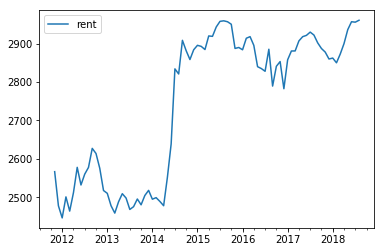

In [201]:
rent_studio_chelsea_clinton.plot()

In [202]:
yelp_bushwick_one_hot_cumsum = yelp_bushwick_one_hot_cumsum.reindex(yelp_williamsburg_one_hot_cumsum.index)
yelp_east_harlem_one_hot_cumsum = yelp_east_harlem_one_hot_zcumsum.reindex(yelp_williamsburg_one_hot_cumsum.index)

NameError: name 'yelp_bushwick_one_hot_cumsum' is not defined

In [203]:
yelp_chelsea_clinton_one_hot_cumsum = yelp_chelsea_clinton_one_hot_cumsum.reindex(yelp_williamsburg_one_hot_cumsum.index)

In [ ]:
yelp_bushwick_one_hot_cumsum.index = rent_studio_bushwick.index
yelp_east_harlem_one_hot_cumsum.index = rent_studio_east_harlem.index
yelp_chelsea_clinton_one_hot_cumsum.index = rent_studio_chelsea_clinton.index

In [ ]:
yelp_cumsum_rent_bushwick = pd.concat([yelp_bushwick_one_hot_cumsum ,rent_studio_bushwick],axis = 1)
yelp_cumsum_rent_east_harlem = pd.concat([yelp_east_harlem_one_hot_cumsum ,rent_studio_east_harlem],axis = 1)

In [ ]:
yelp_cumsum_rent_chelsea_clinton = pd.concat([yelp_chelsea_clinton_one_hot_cumsum ,rent_studio_chelsea_clinton],axis = 1)
yelp_cumsum__percent_inc_rent_chelsea_clinton = yelp_cumsum_rent_chelsea_clinton.pct_change(fill_method = "ffill")

In [ ]:
yelp_cumsum__percent_inc_rent_east_harlem = yelp_cumsum_rent_east_harlem.pct_change(fill_method = "ffill")
yelp_cumsum__percent_inc_rent_bushwick = yelp_cumsum_rent_bushwick.pct_change(fill_method = "ffill")

In [ ]:
# yelp_cumsum__percent_inc_rent_bushwick.to_csv('yelp_cumsum_percent_inc_rent_bushwick.csv')
# yelp_cumsum_rent_bushwick.to_csv('yelp_cumsum_rent_bushwick.csv')

In [ ]:
# yelp_cumsum__percent_inc_rent_east_harlem.to_csv('yelp_cumsum_percent_inc_rent_east_harlem.csv')
# yelp_cumsum_rent_east_harlem.to_csv('yelp_cumsum_rent_east_harlem.csv')

In [ ]:
yelp_cumsum__percent_inc_rent_chelsea_clinton.to_csv('yelp_cumsum_percent_inc_rent_chelsea_clinton.csv')
yelp_cumsum_rent_chelsea_clinton.to_csv('yelp_cumsum_rent_chelsea_clinton.csv')

#### Time Series

In [ ]:
rent_studio_williamsburg['%increase_rent'] = rent_studio_williamsburg.pct_change()

In [ ]:
rent_studio_williamsburg['rent'].plot() # further time series analysis necessary

In [ ]:
# check the distribution
rent_studio_williamsburg['rent'].plot(kind='kde')
plt.show()

In [ ]:
rent_studio_east_harlem['rent'].plot(kind='kde')
plt.show()

In [ ]:
rent_studio_bushwick['rent'].plot(kind='kde')
plt.show()

In [ ]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window=12).mean() # Change window size for different lags
    rolstd = TS.rolling(window=12).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['rent'], autolag='AIC') # change the passengers column as required 
    
    #Plot rolling statistics:
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

In [ ]:
rent_studio_williamsburg['rent'] = rent_studio_williamsburg['rent'].astype('float')

In [ ]:
rent_studio_williamsburg_log = np.log(rent_studio_williamsburg['rent'])

In [ ]:
rent_studio_williamsburg_log = pd.DataFrame(rent_studio_williamsburg_log)

In [ ]:
rolmean_log = rent_studio_williamsburg_log.rolling(window=12).mean()
rolstd_log = rent_studio_williamsburg_log.rolling(window=12).std()
rent_studio_williamsburg_log_moving_avg_diff = rent_studio_williamsburg_log - rolmean_log
rent_studio_williamsburg_log_moving_avg_diff.head(15)

In [ ]:
rent_studio_williamsburg_log_moving_avg_diff = rent_studio_williamsburg_log_moving_avg_diff.dropna()

In [ ]:
stationarity_check(rent_studio_williamsburg_log_moving_avg_diff)

In [ ]:
decomposition_williamsburg = seasonal_decompose(rent_studio_williamsburg['rent'])

# Gather the trend, seasonality and noise of decomposed object
trend_williamsburg = decomposition_williamsburg.trend
seasonal_williamsburg = decomposition_williamsburg.seasonal
residual_williamsburg = decomposition_williamsburg.resid

# Plot gathered statistics
# rcParams['figure.figsize'] = 15, 15
plt.subplot(411)
plt.plot(rent_studio_williamsburg['rent'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_williamsburg, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_williamsburg,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_williamsburg, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# auto correlation -> moving average lag
from statsmodels.graphics.tsaplots import plot_acf
# get the ACF using plot_acf(series)
# rcParams['figure.figsize'] = 15, 6
plot_acf(rent_studio_williamsburg_log_moving_avg_diff)
plt.show()

In [ ]:
# partial auto-correlation -> auto regressive term
from statsmodels.graphics.tsaplots import plot_pacf

# Plot pacf by passing lags=100 as an argument to plot_acf()
plot_pacf(rent_studio_williamsburg_log_moving_avg_diff, lags = 20)
plt.show()